## Abstract

In this notebook, I will be analyzing several climate change data originally taken from the following Kaggle competition:

https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

This dataset is maintained by the Berkeley Earth Foundation. The website can be found here:

http://berkeleyearth.org/

The datasets that we will be working with are as follows:

City Land Temperatures
State Land Temperatures
Global Temperatures by Country

These datasets contained information related to land temperatures that were taken over several years. In this project, I will only be focusing data taken after 1900. 

The major question we will be looking at here is the following:

Is there an increase in land temperature over time? And if so - can we visualize both the rate of change as well as the absolute change in temperature over time? 

I will also attempt to make some conclusions based on the data that is presented in this data. 

In [2]:
## Import dependencies

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [3]:
city_df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
global_temp_by_month = pd.read_csv('GlobalTemperatures.csv')
state_df = pd.read_csv('GlobalLandTemperaturesByState.csv')
global_temp_by_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [4]:
split_date = city_df['dt'].str.split('-',n=2,expand=True)
merge_city = pd.merge(split_date, city_df, left_index=True, right_index=True)
rename_city = merge_city.rename(columns={0: 'Year', 1: 'Month', 2: 'Day'})
drop_city = rename_city.dropna()

In [5]:
## Plot average temperatures of each state for the last 100 years. 

state_df = pd.read_csv('GlobalLandTemperaturesByState.csv')
country_state_df = state_df[state_df['Country']=='United States']
country_state_df.dropna()
state_after = country_state_df[country_state_df['dt']>'1900-01-01']
group_state = state_after.groupby('State').mean()['AverageTemperature']
final_state = group_state.reset_index()

import plotly.express as px
fig = px.scatter(final_state, x='State',y='AverageTemperature')
fig.update_layout(title_text='Average Temperature of US States')
fig.show()

In [6]:
## Find the average temperature of each state by year
split = state_after['dt'].str.split('-',n=2,expand=True)
merge_df = pd.merge(split, state_after, left_index=True, right_index=True)
rename = merge_df.rename(columns={0: 'Year', 1: 'Month', 2: 'Day'})
group_mean = rename.groupby('Year').mean()
reset_df = group_mean.reset_index()
min_year = int(min(reset_df['Year']))
max_year = int(max(reset_df['Year']))
reset_df['Fahrenheit'] = (reset_df['AverageTemperature']*9/5)+32


In [266]:
## Plot average temp of all States by Year in F

import plotly.express as px

fig = px.scatter(reset_df, x='Year',y='AverageTemperature', color = 'AverageTemperature',
                marginal_y='histogram')
fig.update_layout(title_text='Average Temperature of all States by Year in Celsius')
fig.show()

In [267]:
import plotly.express as px

fig = px.scatter(reset_df, x='Year',y='AverageTemperature', color = 'AverageTemperature',
                error_y ='AverageTemperatureUncertainty')
fig.update_layout(title_text='Average Temperature of all States by Year in Celsius - With Errors')
fig.show()

In [269]:
mapping_state = pd.read_csv('50_us_states_all_data.csv')

group_by_state = rename.groupby(['Year','State']).mean()
reset_2 = group_by_state.reset_index()

unique_state = np.array(reset_2['State'].unique())

min_year_arr = []
max_year_arr = []

for i in range(len(unique_state)):
    x = (unique_state[i])
    min_year = reset_2[reset_2['State']==x].iloc[0][2]
    min_year_arr.append(min_year)
    max_year = reset_2[reset_2['State']==x].iloc[-1][2]
    max_year_arr.append(max_year)
    
zip_years = list(zip(min_year_arr,max_year_arr))

new_dict = {'State': unique_state, '1900 Temp': min_year_arr, '2013 Temp': max_year_arr}
new_df = pd.DataFrame(new_dict)
new_df['Delta'] = new_df['2013 Temp']-new_df['1900 Temp']

merge_state = pd.merge(new_df,mapping_state,on='State')
merge_state = pd.merge(new_df,mapping_state,on='State')
merge_state = merge_state[['State', 'Code', '1900 Temp', '2013 Temp', 'Delta']]
merge_state.head()

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=merge_state['Code'],
    z = merge_state['Delta'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Change in Temp"
))

fig.update_layout(
    title_text = 'Temperature By State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [271]:
merge_state.sort_values('Delta',ascending=False).head(5)

State Code  1900 Temp  2013 Temp     Delta
45  Washington   WA   8.829455  10.571778  1.742323
4   California   CA  15.119364  16.845444  1.726081
41       Texas   TX  18.843636  20.425222  1.581586
17       Maine   ME   5.925909   7.505222  1.579313
26      Nevada   NV  11.073364  12.633000  1.559636

In [278]:
merge_state.sort_values('Delta',ascending=False).tail(5)

State Code  1900 Temp  2013 Temp     Delta
18   Maryland   MD  13.963727  14.267778  0.304051
47  Wisconsin   WI   7.809818   8.085333  0.275515
44   Virginia   VA  14.475273  14.731556  0.256283
21  Minnesota   MN   6.717182   6.845444  0.128263
9      Hawaii   HI  22.620636  22.522375 -0.098261

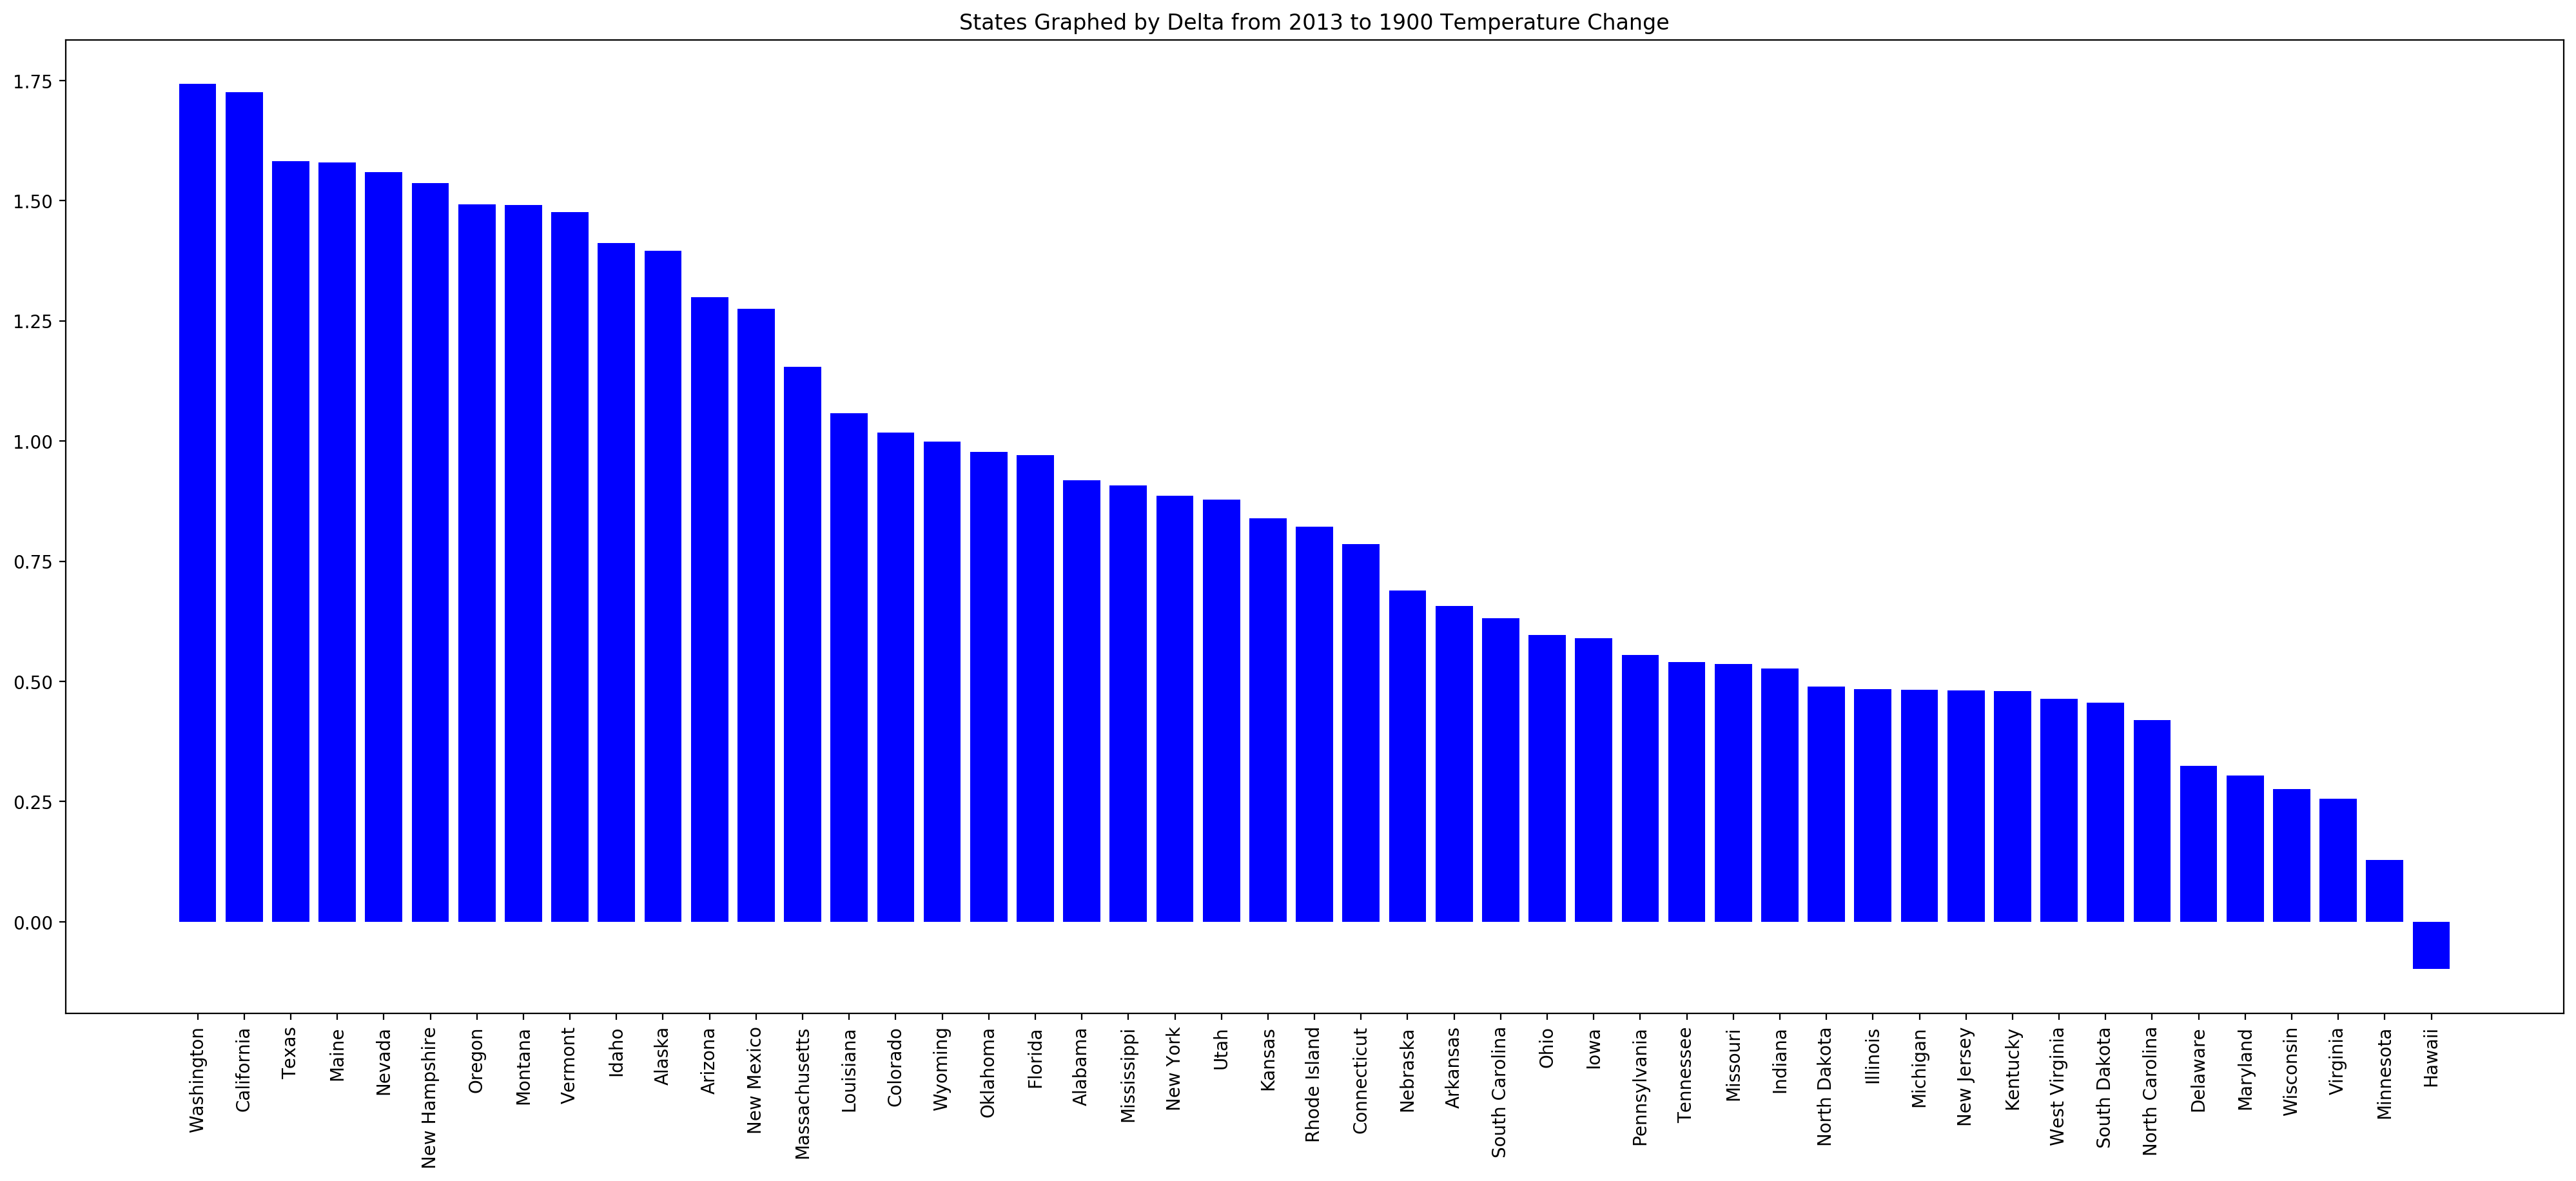

In [283]:
## Graph delta values from highest to lowers

merge_state = merge_state.sort_values('Delta',ascending=False)
figure(figsize=(25, 10), dpi=200, facecolor='w', edgecolor='k')
plt.bar(merge_state['State'],merge_state['Delta'],color='b')
plt.xticks(rotation='vertical')
plt.title('States Graphed by Delta from 2013 to 1900 Temperature Change')
plt.show()

In [39]:
## Graph percent change and cumulative percent change values

sort = reset_2.sort_values(['State','Year'],ascending=True)

sort['Percent Change'] = (sort.groupby('State')['AverageTemperature'].apply(pd.Series.pct_change))
sort['Cumulative Percent'] = sort.groupby('State')['Percent Change'].cumsum()

fig = px.line(sort, x="Year", y="Percent Change")
fig.update_layout(title_text='Percent Change of Average Temperature For All US States')
fig.show()

fig = px.scatter(sort, x="Year", y="Cumulative Percent", color='State')
fig.update_layout(title_text='Running Total of Percent Change for All US States')
fig.show()

In [281]:
## Rate of change graph via Percent 

state = input('What state do you want to see? ')

fig = px.line(sort[sort['State']==state], x="Year", y="Percent Change")
fig.update_layout(title_text='Percent Change of Average Temperature for ' + state)
fig.show()

fig = px.line(sort[sort['State']==state], x="Year", y="Cumulative Percent")
fig.update_layout(title_text='Cumulative Percent Change for ' + state)
fig.show()

What state do you want to see? Alaska


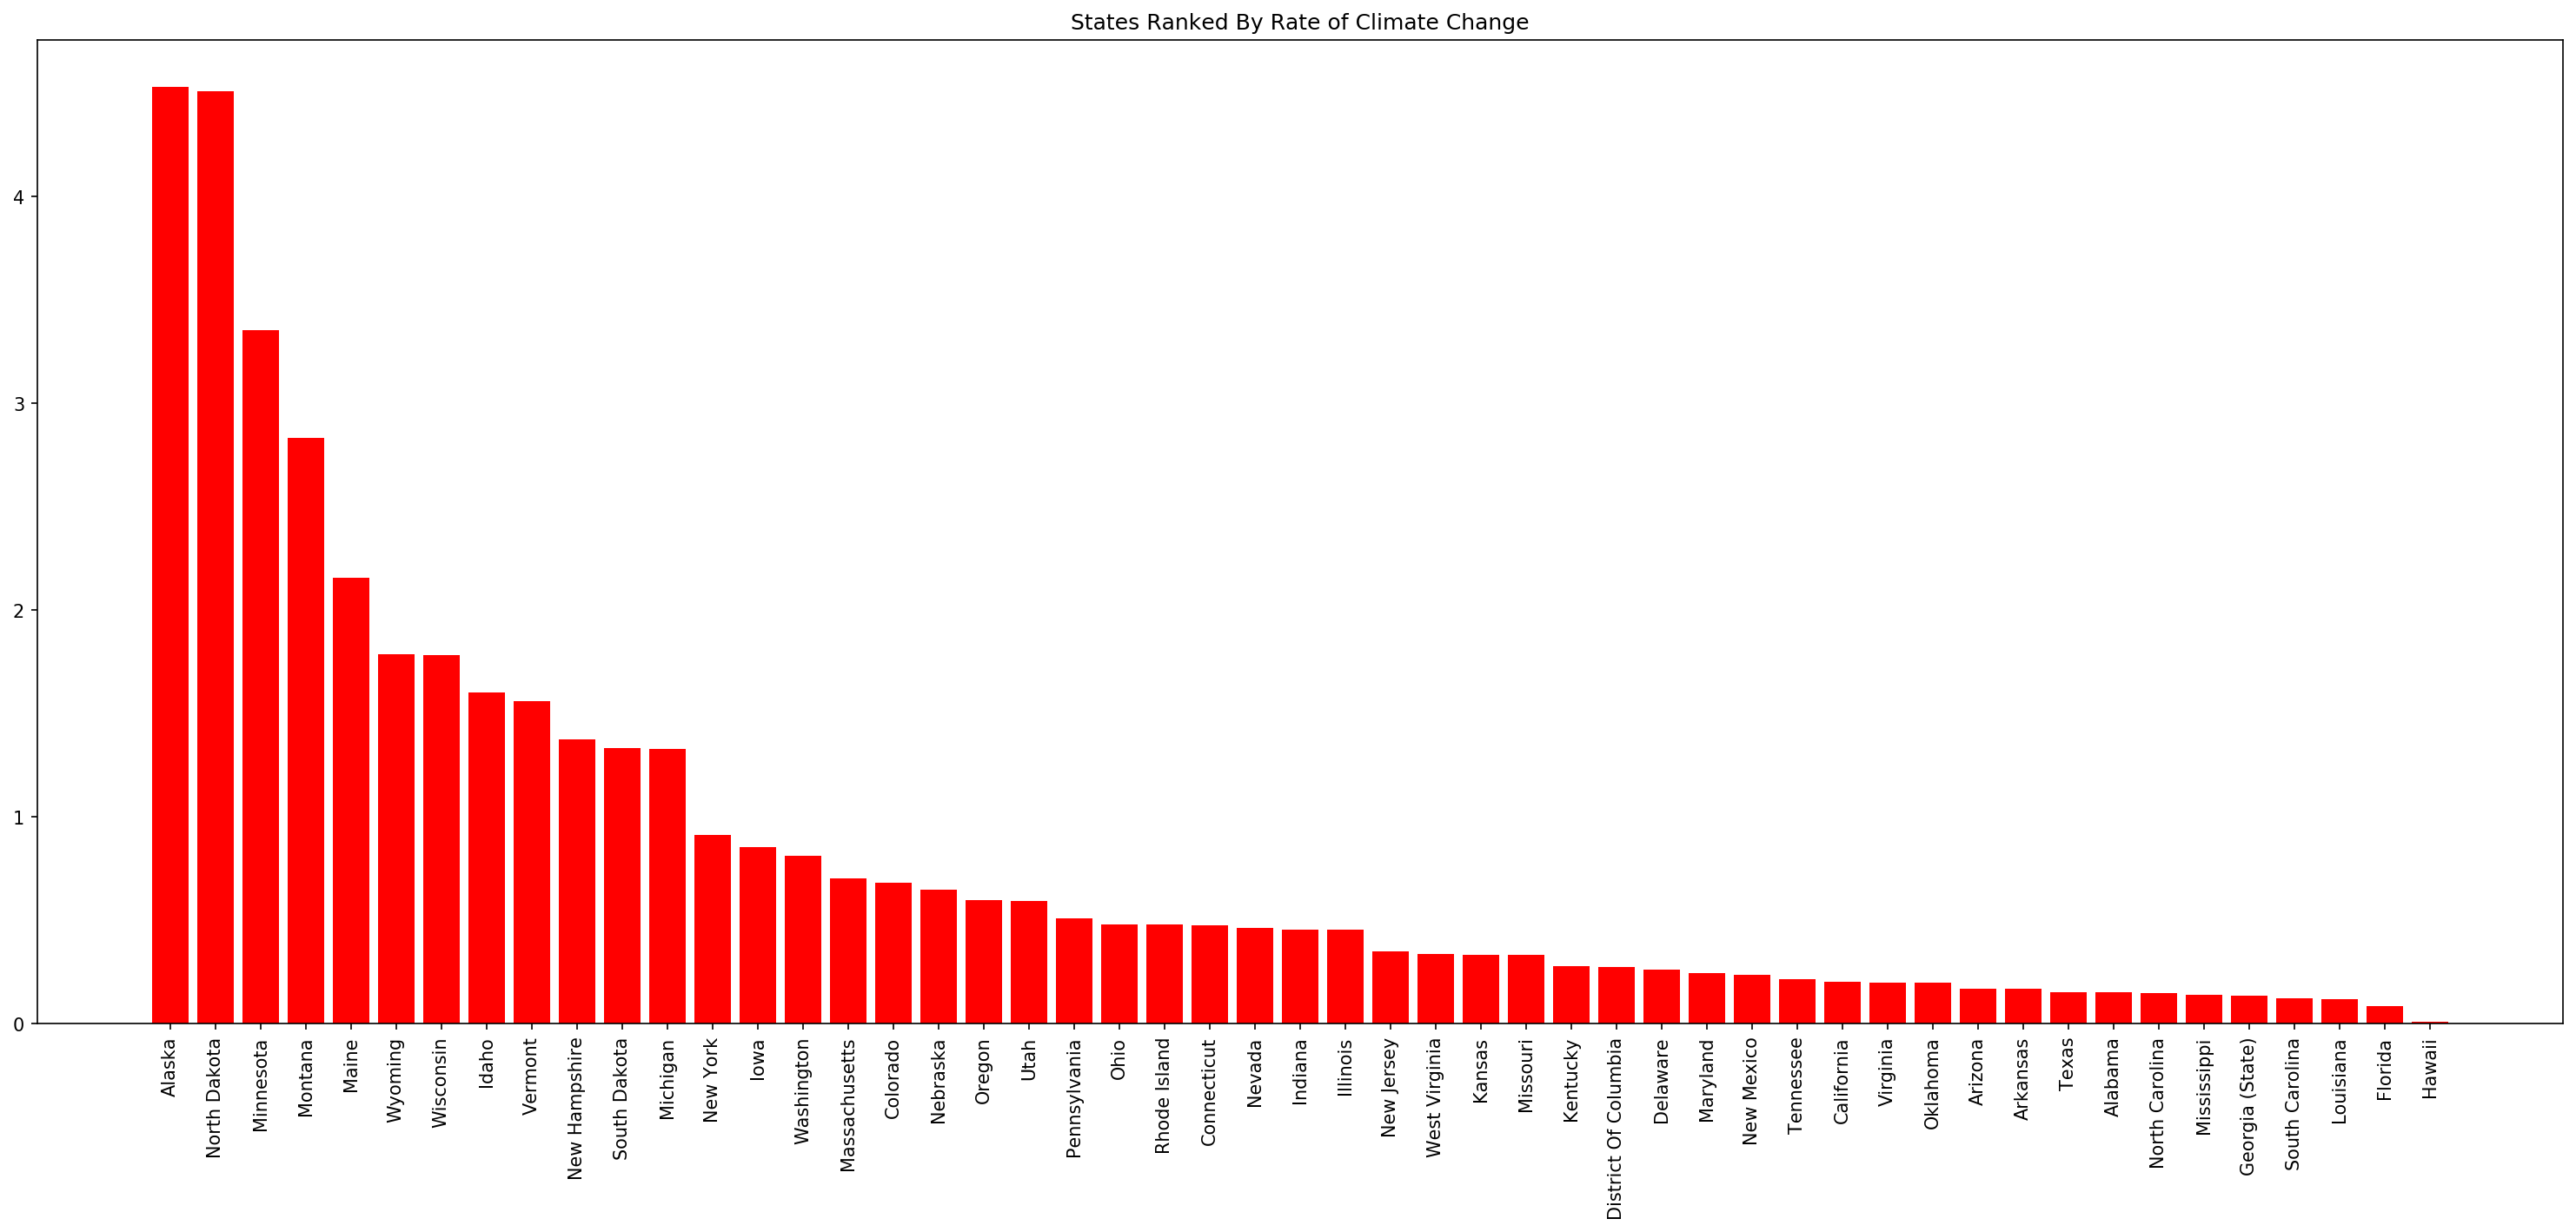

In [282]:
## Graph highest ranking state by cumulative percent change 

sort_cumulative = sort[sort['Year']=='2013'].sort_values('Cumulative Percent', ascending=False)
figure(figsize=(25, 10), dpi=150, facecolor='w')
plt.bar(sort_cumulative['State'],sort_cumulative['Cumulative Percent'],color='r')
plt.xticks(rotation='vertical')
plt.title('States Ranked By Rate of Climate Change')
plt.show()

In [16]:
## Average temperature change in Denver

co_cities = ['Denver']
denver_df = city_df[city_df['City'].isin(co_cities)]
denver_df.reset_index()
denver_df = denver_df[denver_df['dt']>'1900-01-01']

den_split = denver_df['dt'].str.split('-',n=2,expand=True)
den_merge = pd.merge(den_split, denver_df, left_index=True, right_index=True)
den_rename = den_merge.rename(columns={0: 'Year', 1: 'Month', 2: 'Day'})
groupby_year = den_rename.groupby('Year').mean()['AverageTemperature']
reset_group = groupby_year.reset_index()

fig = px.bar(reset_group, x='Year', y='AverageTemperature',
             color='AverageTemperature',
             labels={'temp':'Temp'}, height=400)
fig.update_layout(title_text='Average Temperature of Denver, CO')

fig.show()

In [18]:
## From https://simplemaps.com/data/us-cities
us_cities_df = pd.read_csv('uscities.csv')

In [19]:
## Average Temperature by year for Top 20 Populated Cities in CO

us_cities_top_20 = us_cities_df[us_cities_df['state_id']=='CO']
top_20_co = us_cities_top_20.sort_values(by=['population'], ascending=False).head(20)
top_cities = top_20_co['city']

drop_city = drop_city[drop_city['City'].isin(top_cities)]
group_drop = drop_city.groupby(['City','Year']).mean()['AverageTemperature']
group_reset = group_drop.reset_index()
group_reset = group_reset[group_reset['Year']>'1900-01-01']
group_reset = group_reset[group_reset['City']!='Arvada']
group_reset = group_reset[group_reset['City']!='Lafayette']

fig = px.line(group_reset, x="Year", y="AverageTemperature", color='City')
fig.update_layout(title_text='Average Temperature by Year for Top 20 Populated Cities in CO')
fig.show()

In [20]:
## Define reusable split date function

def split(data):
    split_date = data['dt'].str.split('-',n=2,expand=True)
    merge_city = pd.merge(split_date, city_df, left_index=True, right_index=True)
    rename_city = merge_city.rename(columns={0: 'Year', 1: 'Month', 2: 'Day'})
    drop_city = rename_city.dropna()
    return drop_city

In [21]:
## World data
group_country = split(global_temp_by_country).groupby(['Year','Country']).mean()['AverageTemperature'].reset_index()

In [79]:
import plotly.express as px
gapminder = px.data.gapminder()

group_country = group_country[group_country['Year']>'1900']
group_country = group_country.rename(columns={'Country':'country'})
join_country = pd.merge(gapminder,group_country,on='country').drop_duplicates(subset=['country','Year'])
join_country['Percent Change'] = (join_country.groupby('country')['AverageTemperature'].apply(pd.Series.pct_change))
join_country['Cumulative Percent'] = join_country.groupby('country')['Percent Change'].cumsum()
drop_country = join_country.dropna()

In [76]:
## Plot interactive average worldwide temperature by year
fig = px.choropleth(drop_country, locations="iso_alpha", color="AverageTemperature", hover_name="country", animation_frame="Year", range_color=[0,30])
fig.update_layout(title_text='Average Worldwide Temperature by Year')
fig.show()

In [85]:
country_2013 = drop_country[drop_country['Year']=='2013']
country_2013 = country_2013[country_2013['Cumulative Percent']>0]
sort_country = country_2013.sort_values('Cumulative Percent',ascending=False)

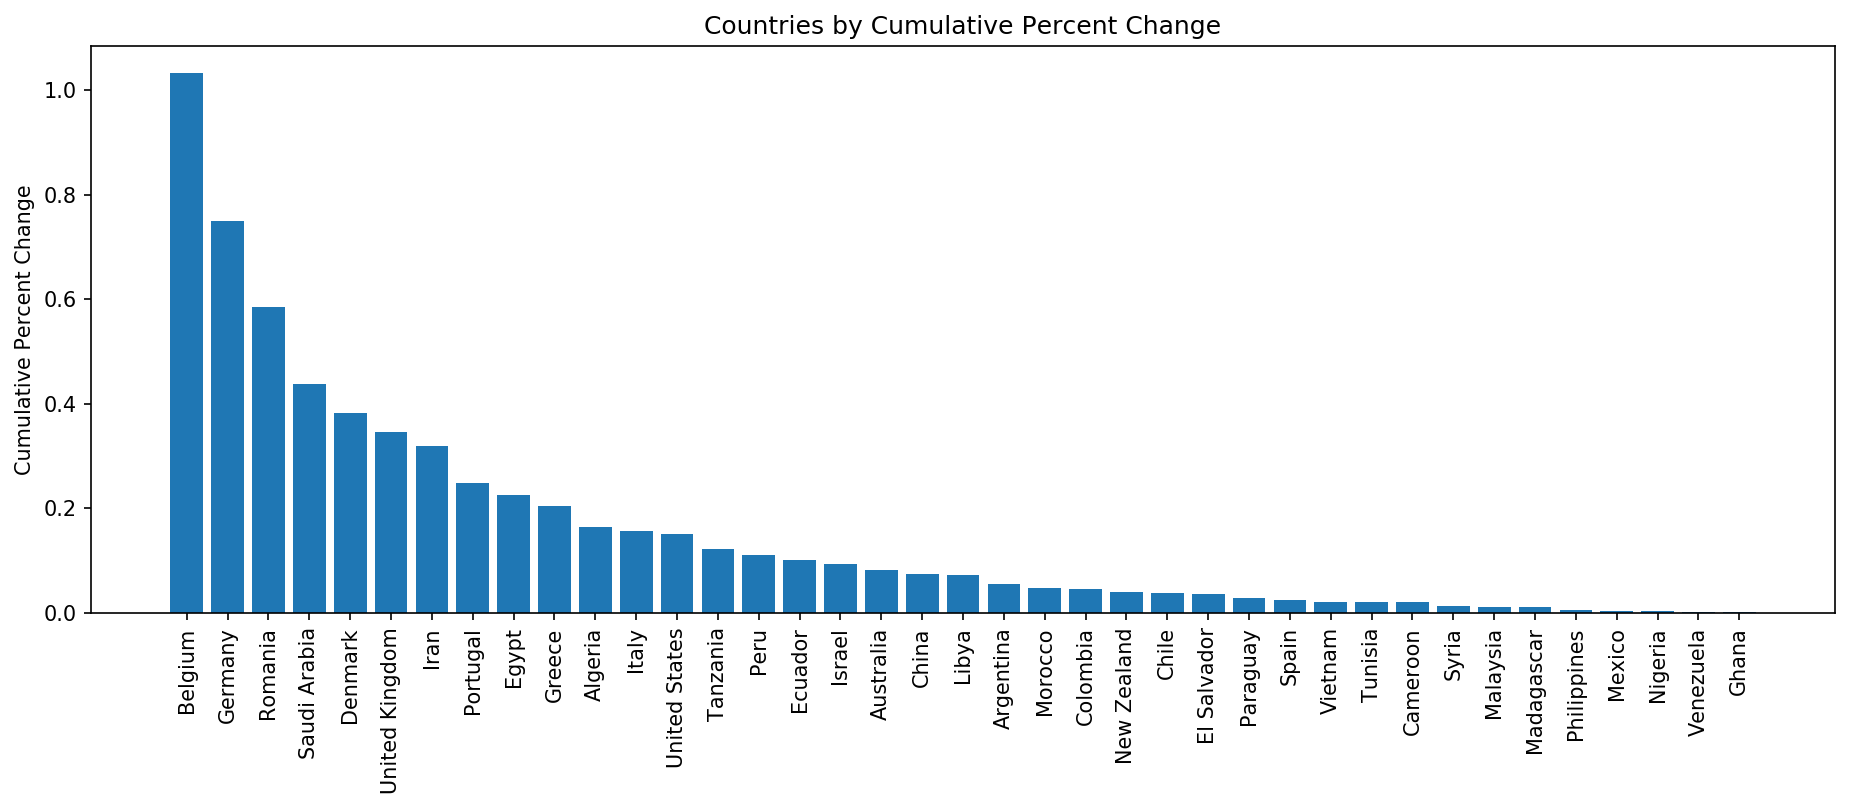

In [86]:
figure(figsize=(15, 5), dpi=150, facecolor='w')
plt.bar(sort_country['country'], sort_country['Cumulative Percent'])
plt.xticks(rotation='vertical')
plt.ylabel('Cumulative Percent Change')
plt.title('Countries by Cumulative Percent Change')
plt.show()

In [252]:
## For fun - looking to see if there's a linear relationship between the average temps of all states 
## and the year.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

X = reset_df['Year'].values.reshape(-1,1)
y = reset_df['AverageTemperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

us_model = LinearRegression().fit(X_train,y_train)
y_pred = us_model.predict(X_test)

y_pred, y_test.values

prediction_dict = {'Predicted Values': y_pred, 'Actual Values': y_test.values}
pred_df = pd.DataFrame(prediction_dict)

intercept = us_model.intercept_
coef = us_model.coef_

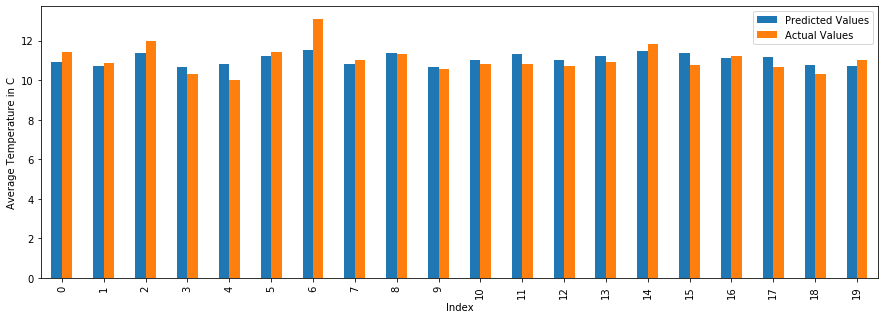

In [260]:
## Show predicted values for dataframe

pred_df.head(20).plot(kind='bar',figsize=(15,5))
plt.xlabel('Index')
plt.ylabel('Average Temperature in C')
plt.show()

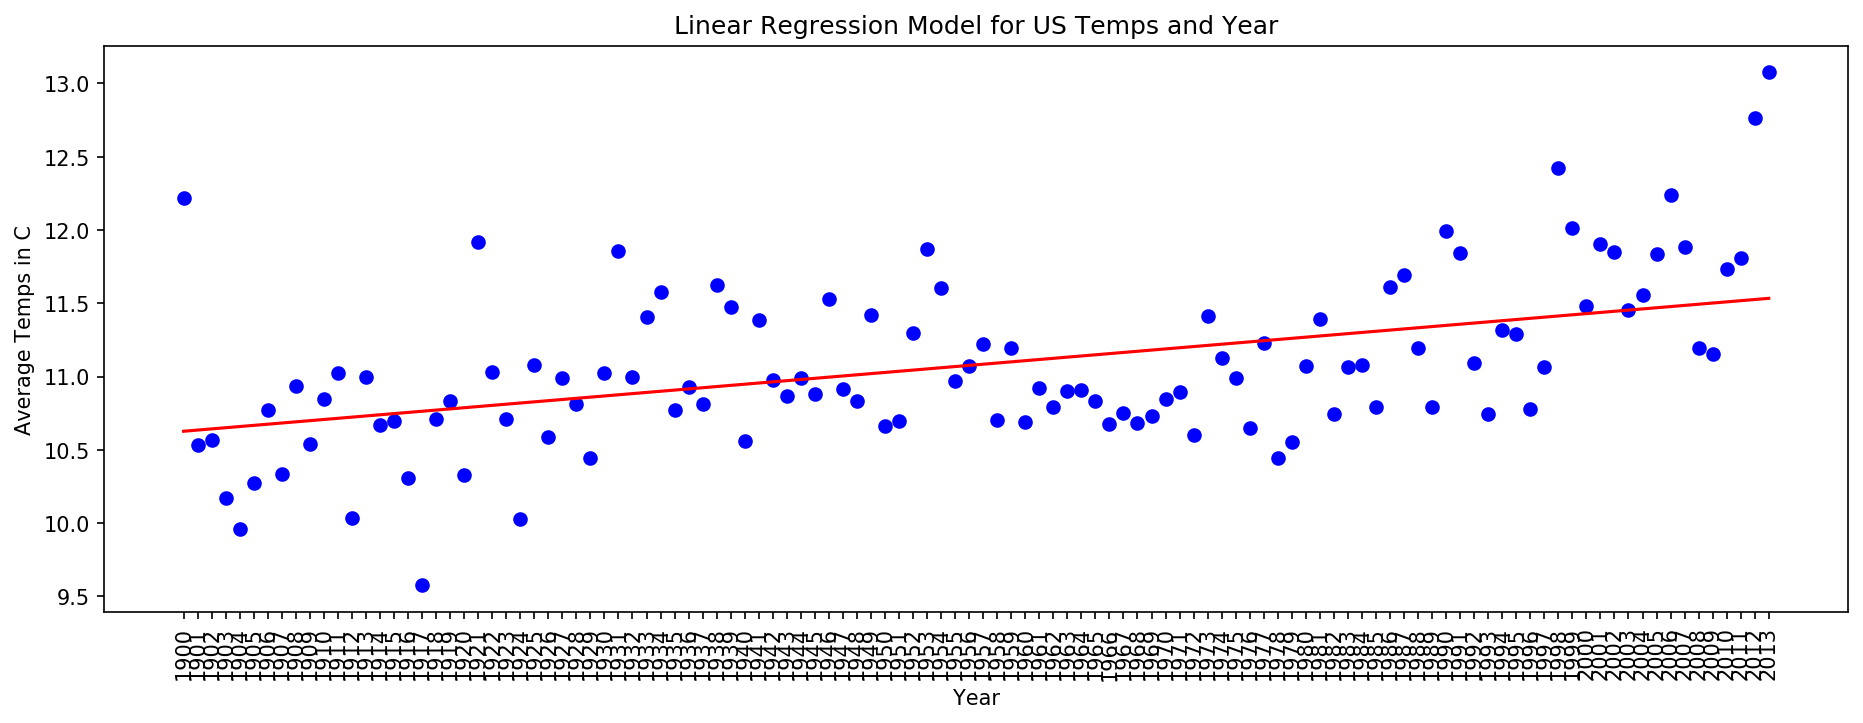

The intercept is: -4.622247863253055 and the slope is [0.008025880853403458]
The predicted temp for [[2019]] is: [11.58200558]
Clearly this does not appear to be a linear relationship


In [259]:
predictions = us_model.predict(reset_df['Year'].values.reshape(-1,1))
figure(figsize=(15, 5), dpi=150, facecolor='w')
plt.scatter(reset_df['Year'],reset_df['AverageTemperature'],color='blue')
plt.xticks(rotation='vertical')
plt.title('Linear Regression Model for US Temps and Year')
plt.ylabel('Average Temps in C')
plt.xlabel('Year')
plt.plot(reset_df['Year'],predictions,color='red')
plt.show()
print('The intercept is: ' +str(intercept) + ' and the slope is ' + str([x for x in coef]))

## Predict new value for 2019

X_new = [[2019,]]
new_prediction = us_model.predict(X_new)
print('The predicted temp for ' + str(X_new) + ' is: ' + str(new_prediction))
print('Clearly this does not appear to be a linear relationship')

## Conclusions

US State Temps ARE Increasing
US City Temps ARE Increasing
World Temps ARE Increasing

The Rate of Change IS Increasing for Some States

A Linear Relationship DOES NOT Fit Our Trends...Is it Exponential? Further Study Needed!